<a href="https://colab.research.google.com/github/matucesari/datamining/blob/main/Redes_neuronales_para_predicci%C3%B3n_de_COVID_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio: Predicción de resultado de test para COVID 19 usando redes neuronales**

En este proyecto aplicaremos redes neuronales del tipo feed-forward para intentar predecir el resultado de tests de para COVID 19 a partir de diversas variables de entrada, entre ellas una serie de valores típicos obtenidos a partir de estudios clínicos, sintomatología general y resultado de tests te otras enfermedades típicas. 

Entre otras cosas aprenderemos :
* Como construir y entrenar una red neuronal multi-capa sencilla para realizar clasificación binaria
* Como trabajar con un problema desbalanceado
* Evaluar el desempeño de las redes en función de su profundidad para decidir cual es la mejor alternativa
* Aplicar el mejor modelo obtenido sobre nuevos casos para obtener predicciones


## Pre-requisitos
* Tener una cuenta de Google (gmail)
* Tener instalado el navegador Google Chrome
* Contar con conectividad a Internet
* Conocimientos básicos de programación con el lenguaje _python_


## Entrega y uso del laboratorio

### Uso

* Antes de cualquier cosa, **cree una copia de este cuaderno:** 
  * `Click` en **File**
  * luego **Save a Copy in Drive**
  * Renombre el archivo con el siguiente formato: `APELLIDO_NOMBRE_LRNA.ipynb` 
* Use el _notebook_, complete las actividades y consignas que se requieran 
* Este laboratorio es una actividad *individual* pero se fomenta el intercambio de opiniones en clase

### Entrega

Una vez finalizado el laboratorio, complete [el formulario de entrega](...) indicando:
 * `link de su notebook`. El mismo se obtiene si realiza click en **Compartir/Share** (esquina superior derecha) y luego en **Obtener link para compartir/Get shareable link**  
 


_______________________

En primer lugar importamos todos los módulos que usaremos durante todo el proyecto. 

In [ ]:

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:
# Función para obtener cuenta de ejemplos con valores nulos por cada variable
def get_null_counts(df):
  null_columns=df.columns[df.isnull().any()]
  nan_count_df = pd.DataFrame(data=df[null_columns].isnull().sum(),columns=['NaN count'])
  nan_count_df.sort_values('NaN count',ascending=False,inplace=True)
  return nan_count_df


## PARTE I : Pre-procesamiento y análisis inicial del dataset (EDA)


Vamos a trabajar con un [dataset de pacientes recolectado en el Hospital Isrealita Albert Einstein en São Paulo, Brazil](https://www.kaggle.com/einsteindata4u/covid19#dataset.xlsx)

Este dataset contiene datos anonimizados de los pacientes de los cuales se les realizó el test SARS-CoV-2 RT-PCR junto con otros tests de laboratorio adicionales que se les realizaron en su visita al hospital.

Para trabajar más facilmente desde este notebook, este archivo está alojado en _github_ de manera de poder leerlo directamente. Lo primero que hacemos entonces es leerlo en un `DataFrame`.

In [47]:
url = 'https://github.com/matucesari/datamining/blob/main/brasil_einstein_covid_tests.xlsx?raw=true'
raw_data_einstein = pd.read_excel(url)
print(raw_data_einstein.shape)
raw_data_einstein.head()

(5644, 111)


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En su versión más completa y cruda este conjunto de datos tiene ~5600 ejemplos y ~111 columnas. 

A continuación extraemos solo las variables numéricas que vamos a usar. Dejaremos afuera variables como el ID del paciente y algunas que producen error así como variables que no son numéricas.

In [ ]:

# vamos a elminar estas columnas
vars_to_drop = [
  'Patient ID',
  # numerics but failing
  'Mean platelet volume', 
  'Mean corpuscular hemoglobin concentration (MCHC)',
  'Gamma-glutamyltransferase',
  'Ionized calcium',
  'Creatine phosphokinase (CPK)',
]

# estas variables son numericas
numeric_vars = [
  'Patient age quantile',
  'Hematocrit',
  'Hemoglobin',
  'Platelets',
  'Red blood Cells',
  'Lymphocytes',
  'Eosinophils',
  'Mean corpuscular volume (MCV)',
  'Monocytes',
  'Red blood cell distribution width (RDW)',
  'Serum Glucose',
  'Neutrophils',
  'Urea',
  'Proteina C reativa mg/dL',
  'Creatinine',
  'Potassium',
  'Sodium',
  'Alanine transaminase',
  'Aspartate transaminase',
  'Total Bilirubin',
  'Direct Bilirubin',
  'Indirect Bilirubin',
  'Alkaline phosphatase',
  'Magnesium',
  'pCO2 (venous blood gas analysis)',
  'Hb saturation (venous blood gas analysis)',
  'Base excess (venous blood gas analysis)',
  'pO2 (venous blood gas analysis)',
  'Total CO2 (venous blood gas analysis)',
  'pH (venous blood gas analysis)',
  'HCO3 (venous blood gas analysis)',
  'Rods #',
  'Segmented',
  'Promyelocytes',
  'Metamyelocytes',
  'Myelocytes',
  'Urine - Density',
  'Urine - Red blood cells',
  'Relationship (Patient/Normal)',
  'International normalized ratio (INR)',
  'Lactic Dehydrogenase',
  'Ferritin',
  'Arterial Lactic Acid',
]

boolean_vars = [
  # estas son booleanas y no las vamos a contemplar aqui
  'Patient addmited to regular ward (1=yes, 0=no)',
  'Patient addmited to semi-intensive unit (1=yes, 0=no)',
  'Patient addmited to intensive care unit (1=yes, 0=no)'
]


categorical_vars = [
  # estas son categoricas y no las vamos a contemplar aqui
  # solo el 25% del dataset tiene estas variables
  'Respiratory Syncytial Virus',
  'Influenza A',
  'Influenza B',
  'Parainfluenza 1',
  'CoronavirusNL63',
  'Rhinovirus/Enterovirus',
  'Coronavirus HKU1',
  'Parainfluenza 3',
  'Chlamydophila pneumoniae',
  'Adenovirus',
  'Parainfluenza 4',
  'Coronavirus229E',
  'CoronavirusOC43',
  'Inf A H1N1 2009',
  'Bordetella pertussis',
  'Metapneumovirus',
  'Parainfluenza 2',
  # para estas tenemos solo 15% de los casos con valor
  'Influenza B, rapid test',
  'Influenza A, rapid test',

]

# este es el nombre de la columna que contiene los resultados del test
target_variable = 'SARS-Cov-2 exam result'

# armamos una lista con las columnas que quedaran: el total menos las que queremos eliminar
vars_to_work = list(set(raw_data_einstein.columns) - set(vars_to_drop) - set(boolean_vars) - set(categorical_vars))

# a partir de ahora trabajaremos con el DataFrame working_data
working_data = raw_data_einstein[vars_to_work]

print('Tamaño del dataset')
print(working_data.shape)



Tamaño del dataset
(5644, 88)


En primera instancia vemos la cantidad de ejemplos con valores nulos en el dataset por columnas

In [ ]:
null_count = get_null_counts(working_data)

print('\nCantidad de filas con Null por columna')
print(null_count.to_string())



Cantidad de filas con Null por columna
                                                  NaN count
Partial thromboplastin time (PTT)                      5644
Prothrombin time (PT), Activity                        5644
Mycoplasma pneumoniae                                  5644
Urine - Sugar                                          5644
D-Dimer                                                5644
Fio2 (venous blood gas analysis)                       5643
Urine - Nitrite                                        5643
Vitamin B12                                            5641
Lipase dosage                                          5636
Albumin                                                5631
Arteiral Fio2                                          5624
Phosphor                                               5624
Ferritin                                               5621
Hb saturation (arterial blood gases)                   5617
HCO3 (arterial blood gas analysis)                     5617


Para tener un dataset más limipio, también vamos a quitar del analisis aquellas columnas para las cuales todas las filas tienen valores nulos. 

In [ ]:
nrows_limit = working_data.shape[0]

cols_empty = null_count.loc[null_count['NaN count'] >= nrows_limit].index.values
print('More columns to drop :\n{}'.format(cols_empty))

# armamos una lista con las columnas que quedaran: el total menos las que tienen todas las filas en nulo
vars_to_work = list(set(working_data.columns) - set(cols_empty))

# obtenemos solo las columnas de interés
working_data = working_data[vars_to_work]
print(working_data.shape)
print(working_data.columns)
working_data.head(3)

More columns to drop :
['Partial thromboplastin time\xa0(PTT)\xa0'
 'Prothrombin time (PT), Activity' 'Mycoplasma pneumoniae' 'Urine - Sugar'
 'D-Dimer']
(5644, 83)
Index(['Alanine transaminase', 'Monocytes', 'Ferritin', 'Myelocytes',
       'Vitamin B12', 'Sodium', 'Neutrophils', 'Mean platelet volume ',
       'Aspartate transaminase', 'Proteina C reativa mg/dL',
       'pH (venous blood gas analysis)', 'Urine - Crystals', 'Urine - Protein',
       'Alkaline phosphatase', 'Urine - Aspect', 'Urine - pH', 'Hemoglobin',
       'Urine - Hyaline cylinders', 'ctO2 (arterial blood gas analysis)',
       'Myeloblasts', 'International normalized ratio (INR)',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Serum Glucose',
       'Platelets', 'Hematocrit', 'Direct Bilirubin', 'Urine - Urobilinogen',
       'Eosinophils', 'Strepto A', 'Hb saturation (arterial blood gases)',
       'Urine - Red blood cells', 'Urine - Leukocytes', 'Leukocytes',
       'SARS-Cov-2 exam result', 'Base e

,Alanine transaminase,Monocytes,Ferritin,Myelocytes,Vitamin B12,Sodium,Neutrophils,Mean platelet volume,Aspartate transaminase,Proteina C reativa mg/dL,pH (venous blood gas analysis),Urine - Crystals,Urine - Protein,Alkaline phosphatase,Urine - Aspect,Urine - pH,Hemoglobin,Urine - Hyaline cylinders,ctO2 (arterial blood gas analysis),Myeloblasts,International normalized ratio (INR),Mean corpuscular hemoglobin concentration (MCHC),Serum Glucose,Platelets,Hematocrit,Direct Bilirubin,Urine - Urobilinogen,Eosinophils,Strepto A,Hb saturation (arterial blood gases),Urine - Red blood cells,Urine - Leukocytes,Leukocytes,SARS-Cov-2 exam result,Base excess (venous blood gas analysis),Phosphor,HCO3 (venous blood gas analysis),Gamma-glutamyltransferase,Fio2 (venous blood gas analysis),Potassium,...,Magnesium,Urine - Density,Creatinine,HCO3 (arterial blood gas analysis),Mean corpuscular volume (MCV),Arteiral Fio2,Lactic Dehydrogenase,Albumin,Total Bilirubin,pO2 (venous blood gas analysis),Urine - Nitrite,Lymphocytes,Urine - Ketone Bodies,Rods #,Mean corpuscular hemoglobin (MCH),Basophils,Lipase dosage,Arterial Lactic Acid,Segmented,Total CO2 (arterial blood gas analysis),Urine - Hemoglobin,Urine - Color,Relationship (Patient/Normal),Urine - Bile pigments,Total CO2 (venous blood gas analysis),Urea,Indirect Bilirubin,Hb saturation (venous blood gas analysis),pO2 (arterial blood gas analysis),Metamyelocytes,Creatine phosphokinase (CPK),Base excess (arterial blood gas analysis),Red blood cell distribution width (RDW),Red blood Cells,Promyelocytes,pCO2 (arterial blood gas analysis),Ionized calcium,Urine - Granular cylinders,pH (arterial blood gas analysis),Patient age quantile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1,NaN,0.357547,NaN,NaN,NaN,0.862512,-0.619086,0.010677,NaN,-0.147895,NaN,NaN,NaN,NaN,NaN,NaN,-0.02234,NaN,NaN,NaN,NaN,-0.95079,-0.140648,-0.517413,0.236515,NaN,NaN,1.482158,NaN,NaN,NaN,NaN,-0.09461,negative,NaN,NaN,NaN,NaN,NaN,-0.305787,...,NaN,NaN,2.089928,NaN,0.166192,NaN,NaN,NaN,NaN,NaN,NaN,0.318366,NaN,NaN,-0.292269,-0.223767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.198059,NaN,NaN,NaN,NaN,NaN,NaN,-0.625073,0.102004,NaN,NaN,NaN,NaN,NaN,17
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


Para tener una idea del balance de clases del dataset, vemos la cuenta de valores únicos en esta columna.

In [ ]:
# para tener una idea del balance de clases del dataset, vemos la cuenta de valores únicos en esta columna
print(working_data[target_variable].value_counts())
print(working_data.shape)

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64
(5644, 83)


Como era de esperarse la cantidad de ejempos con resultados `positive` es mucho menor la cantidad de ejemplos negativos, por lo que tendremos que considerar este desbalanceo más adelante para tener resultados más fiables. 

Además vamos a generar una variable numerica `y` la cual valdrá `1` para los datapoints con resultado de test `positive` y `0` para los `negative`. Esto es necesario por que la salida de la red debe ser numerica como sus entradas.

In [ ]:
# iniciamos la columna con 0 por defecto
working_data['y'] = 0
# aquellas filas donde la variable objetivo es 'positive' los seteamos en 1
working_data.loc[working_data[target_variable]=='positive',['y']] = 1

# imprimimos algunos casos positivos y negativos
print(working_data.loc[working_data.y == 1][[target_variable,'y']].sample(3))
print(working_data.loc[working_data.y == 0][[target_variable,'y']].sample(3))


     SARS-Cov-2 exam result  y
5301               positive  1
3640               positive  1
1479               positive  1
     SARS-Cov-2 exam result  y
987                negative  0
1311               negative  0
4223               negative  0


Como observamos anteriormente, este dataset está muy desbalanceado ya que hay muchisimas mas instancias de casos con resultado `negativo` que `positivo`. Para evitar problemas en perormance del modelo vamos a tomar una muestra de los casos positivos de tamaño igual a los negativos asi tenemos un dataset balanceado.

In [ ]:
# mostramos el count de clases antes de balancear
print(working_data['y'].value_counts())

# separamos el dataframe en su parte positiva y negativa
working_data_pos = working_data.loc[working_data.y == 1]
working_data_neg = working_data.loc[working_data.y == 0]

# vamos a balancear tomando una muestra de la clase mayoritaria (negativa) del tamaño de la clase minoritaria (positivos)
working_data = pd.concat([
  working_data_pos,
  working_data_neg.sample(working_data_pos.shape[0])
])

# volvemos a mostrar el count de clases
print(working_data['y'].value_counts())


0    5086
1     558
Name: y, dtype: int64
1    558
0    558
Name: y, dtype: int64


Debido a que ahora hemos submuestreado el dataset, volvemos a repetir el proceso de eliminacion de columnas con todas las filas nulas.

In [ ]:
print(working_data.shape)
null_count = get_null_counts(working_data)

print('\nCantidad de filas con Null por columna')
null_count

(1116, 84)

Cantidad de filas con Null por columna


,NaN count
Vitamin B12,1116
Fio2 (venous blood gas analysis),1116
Urine - Nitrite,1116
Albumin,1115
Phosphor,1114
...,...
Basophils,985
Mean corpuscular hemoglobin (MCH),985
Lymphocytes,985
Monocytes,985


In [ ]:
nrows_limit = working_data.shape[0]

cols_empty = null_count.loc[null_count['NaN count'] >= nrows_limit].index.values
print('More columns to drop :\n{}'.format(cols_empty))

# armamos una lista con las columnas que quedaran: el total menos las que tienen todas las filas en nulo
vars_to_work = list(set(working_data.columns) - set(cols_empty))

# obtenemos solo las columnas de interés
working_data = working_data[vars_to_work]
print(working_data.shape)
print(working_data.columns)
working_data.head(3)

More columns to drop :
['Vitamin B12' 'Fio2 (venous blood gas analysis)' 'Urine - Nitrite']
(1116, 81)
Index(['Alanine transaminase', 'Monocytes', 'Ferritin', 'Myelocytes', 'Sodium',
       'Neutrophils', 'y', 'Mean platelet volume ', 'Aspartate transaminase',
       'Proteina C reativa mg/dL', 'pH (venous blood gas analysis)',
       'Urine - Crystals', 'Urine - Protein', 'Alkaline phosphatase',
       'Urine - Aspect', 'Urine - pH', 'Hemoglobin',
       'Urine - Hyaline cylinders', 'ctO2 (arterial blood gas analysis)',
       'Myeloblasts', 'International normalized ratio (INR)',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Serum Glucose',
       'Platelets', 'Hematocrit', 'Direct Bilirubin', 'Urine - Urobilinogen',
       'Eosinophils', 'Strepto A', 'Hb saturation (arterial blood gases)',
       'Urine - Red blood cells', 'Urine - Leukocytes', 'Leukocytes',
       'SARS-Cov-2 exam result', 'Base excess (venous blood gas analysis)',
       'Phosphor', 'HCO3 (venous blo

,Alanine transaminase,Monocytes,Ferritin,Myelocytes,Sodium,Neutrophils,y,Mean platelet volume,Aspartate transaminase,Proteina C reativa mg/dL,pH (venous blood gas analysis),Urine - Crystals,Urine - Protein,Alkaline phosphatase,Urine - Aspect,Urine - pH,Hemoglobin,Urine - Hyaline cylinders,ctO2 (arterial blood gas analysis),Myeloblasts,International normalized ratio (INR),Mean corpuscular hemoglobin concentration (MCHC),Serum Glucose,Platelets,Hematocrit,Direct Bilirubin,Urine - Urobilinogen,Eosinophils,Strepto A,Hb saturation (arterial blood gases),Urine - Red blood cells,Urine - Leukocytes,Leukocytes,SARS-Cov-2 exam result,Base excess (venous blood gas analysis),Phosphor,HCO3 (venous blood gas analysis),Gamma-glutamyltransferase,Potassium,Urine - Esterase,...,Urine - Yeasts,Magnesium,Urine - Density,Creatinine,HCO3 (arterial blood gas analysis),Mean corpuscular volume (MCV),Arteiral Fio2,Lactic Dehydrogenase,Albumin,Total Bilirubin,pO2 (venous blood gas analysis),Lymphocytes,Urine - Ketone Bodies,Rods #,Mean corpuscular hemoglobin (MCH),Basophils,Lipase dosage,Arterial Lactic Acid,Segmented,Total CO2 (arterial blood gas analysis),Urine - Hemoglobin,Urine - Color,Relationship (Patient/Normal),Urine - Bile pigments,Total CO2 (venous blood gas analysis),Urea,Indirect Bilirubin,Hb saturation (venous blood gas analysis),pO2 (arterial blood gas analysis),Metamyelocytes,Creatine phosphokinase (CPK),Base excess (arterial blood gas analysis),Red blood cell distribution width (RDW),Red blood Cells,Promyelocytes,pCO2 (arterial blood gas analysis),Ionized calcium,Urine - Granular cylinders,pH (arterial blood gas analysis),Patient age quantile
67,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
284,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
513,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


## PARTE II : Ingeniería de features y entrenamiento

Ahora que tenemos el dataset mejor preparado para entrenar sobre el, vamos a comenzar la etapa de modelado.

El primer paso es dividir el  total de datos en 3 conjuntos disjuntos:
* `train-set`: será un `80%` del total de ejemplos y será usado para entrenar
* `validation-set` : será un `10%` del total y será usado para elegir el mejor putno de corte en el entrenamiento y la mejor arquitectura. 
* `test-set` : será un `10%` del total de ejemplos y será usado para evaluar el modelo final en datos no antes visto durante el entrenamiento.


In [ ]:
from sklearn.model_selection import train_test_split
train_df,test_df= train_test_split(working_data,test_size = 0.1)
train_df,val_df = train_test_split(train_df,test_size = 0.1)
print(train_df.shape)
train_df.head(3)

(903, 81)


,Alanine transaminase,Monocytes,Ferritin,Myelocytes,Sodium,Neutrophils,y,Mean platelet volume,Aspartate transaminase,Proteina C reativa mg/dL,pH (venous blood gas analysis),Urine - Crystals,Urine - Protein,Alkaline phosphatase,Urine - Aspect,Urine - pH,Hemoglobin,Urine - Hyaline cylinders,ctO2 (arterial blood gas analysis),Myeloblasts,International normalized ratio (INR),Mean corpuscular hemoglobin concentration (MCHC),Serum Glucose,Platelets,Hematocrit,Direct Bilirubin,Urine - Urobilinogen,Eosinophils,Strepto A,Hb saturation (arterial blood gases),Urine - Red blood cells,Urine - Leukocytes,Leukocytes,SARS-Cov-2 exam result,Base excess (venous blood gas analysis),Phosphor,HCO3 (venous blood gas analysis),Gamma-glutamyltransferase,Potassium,Urine - Esterase,...,Urine - Yeasts,Magnesium,Urine - Density,Creatinine,HCO3 (arterial blood gas analysis),Mean corpuscular volume (MCV),Arteiral Fio2,Lactic Dehydrogenase,Albumin,Total Bilirubin,pO2 (venous blood gas analysis),Lymphocytes,Urine - Ketone Bodies,Rods #,Mean corpuscular hemoglobin (MCH),Basophils,Lipase dosage,Arterial Lactic Acid,Segmented,Total CO2 (arterial blood gas analysis),Urine - Hemoglobin,Urine - Color,Relationship (Patient/Normal),Urine - Bile pigments,Total CO2 (venous blood gas analysis),Urea,Indirect Bilirubin,Hb saturation (venous blood gas analysis),pO2 (arterial blood gas analysis),Metamyelocytes,Creatine phosphokinase (CPK),Base excess (arterial blood gas analysis),Red blood cell distribution width (RDW),Red blood Cells,Promyelocytes,pCO2 (arterial blood gas analysis),Ionized calcium,Urine - Granular cylinders,pH (arterial blood gas analysis),Patient age quantile
672,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
5534,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
5627,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


Verificamos que el balance se mantenga en los conjuntos de `train`, `test` y `validation`, usando la función `get_class_weights`.

In [ ]:
'''
  Función para calcular proporciones de clases y obtener pesos para equilibrarlas
'''
def get_class_weights(df,target_col='y'):
  # función para obtener pesos acorde al desbalanceo de clases en caso que sea necesario
  print(df[target_col].value_counts())
  neg, pos = np.bincount(df[target_col])
  total = neg + pos
  print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
  # Scaling by total/2 helps keep the loss to a similar magnitude.
  # The sum of the weights of all examples stays the same.
  weight_for_0 = (1 / neg)*(total)/2.0 
  weight_for_1 = (1 / pos)*(total)/2.0

  class_weight = {0: weight_for_0, 1: weight_for_1}

  print('Weight for class 0: {:.2f}'.format(weight_for_0))
  print('Weight for class 1: {:.2f}'.format(weight_for_1))
  return class_weight


In [ ]:
print('\nTrain class weghting')
class_wt = get_class_weights(train_df,'y')
print(class_wt)
print('\nValidation class weghting')
get_class_weights(val_df,'y')
print('\nTest class weghting')
get_class_weights(test_df,'y')


Train class weghting
1    458
0    445
Name: y, dtype: int64
Examples:
    Total: 903
    Positive: 458 (50.72% of total)

Weight for class 0: 1.01
Weight for class 1: 0.99
{0: 1.0146067415730338, 1: 0.9858078602620087}

Validation class weghting
0    54
1    47
Name: y, dtype: int64
Examples:
    Total: 101
    Positive: 47 (46.53% of total)

Weight for class 0: 0.94
Weight for class 1: 1.07

Test class weghting
0    59
1    53
Name: y, dtype: int64
Examples:
    Total: 112
    Positive: 53 (47.32% of total)

Weight for class 0: 0.95
Weight for class 1: 1.06


{0: 0.9491525423728814, 1: 1.0566037735849056}

Debido a que tenemos los datos en formato de dataframe, idealmente necesitamos extraerlos en matrices para despues poder transformar todo a numérico. 

Para esta extracción definimos la función `get_arrays_from_data_frame`.


In [ ]:
'''
  Función para transformar un dataset en formato DataFrame en matriz así como la 
  columna de la variable objetivo etiquetada
'''
def get_arrays_from_data_frame(
    df, # DataFrame de entrada
    numeric_vars, # lista de columnas que contienen variables numéricas 
    y_col = 'y' # nombre de la columna que contiene la variable objetivo etiquetada
    ):
  # extraemos los valores de la porción del DataFrame que contiene valores numéricos en forma de matriz
  X_numeric = df[numeric_vars].values
  print(X_numeric.shape)
  # extraemos la columna que contiene la variable objetivo etiquetada en formato de arreglo
  y = df[y_col].values
  print(y.shape)
  # retornamos eso en una tupla de 4 elementos
  return X_numeric,y


In [ ]:
# repetimos el proceso para los tres dataframe
# vamos a obtemer matrices numericas y el arreglo de etiquetas
train_X_numeric,train_y = get_arrays_from_data_frame(train_df,numeric_vars,'y')
val_X_numeric,val_y = get_arrays_from_data_frame(val_df,numeric_vars,'y')
test_X_numeric,test_y = get_arrays_from_data_frame(test_df,numeric_vars,'y')

print('Etiquetas del train-set :\n{}'.format(train_y[:3]))
print('Matriz numerica del train-set :\n{}'.format(train_X_numeric[:3]))

(903, 43)
(903,)
(101, 43)
(101,)
(112, 43)
(112,)
Etiquetas del train-set :
[0 1 1]
Matriz numerica del train-set :
[[19. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan]
 [ 9. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan]
 [ 8. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan]]


Como se ve el dataset tiene muchas variables con valores no asignados o desconocidos. Vamos a imputar los valores faltantes asignando para ellos la `mediana` de la columna correspondiente.



In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(train_X_numeric)

train_X_numeric = imputer.transform(train_X_numeric)
print(train_X_numeric)

test_X_numeric = imputer.transform(test_X_numeric)
print(test_X_numeric)

val_X_numeric= imputer.transform(val_X_numeric)
print(val_X_numeric)

[[19.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 [ 9.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 [ 8.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 ...
 [15.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 [15.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 [10.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]]
[[15.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 [ 6.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 [ 5.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 ...
 [ 2.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 [14.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]
 [ 5.          0.17929401  0.22828403 ... -0.40989739  0.03415509
  -0.62870961]]
[[ 5.          0

Es conveniente que todas las variables de entrada de la red tengan escalas similares de valores por lo que cada matríz será escalada para tener valores entre **-1 y 1**

In [ ]:
#Pre-processing the data
from sklearn.preprocessing import MinMaxScaler

# Scaling numeric variables with MinMax
scaler_numeric = MinMaxScaler((-1,1))


# ajustamos el Scaler solo sobre el trainset
X_train = scaler_numeric.fit_transform(train_X_numeric)

# sobre el validation y test set solo aplicamos la transformación
X_val = scaler_numeric.transform(val_X_numeric)
X_test = scaler_numeric.transform(test_X_numeric)


print('Matriz numerica del train-set :\n{}'.format(X_train[:3]))

Matriz numerica del train-set :
[[ 1.00000000e+00  3.77880216e-01  2.80000080e-01 -7.47562294e-01
   9.52381043e-02 -1.19914322e-01 -8.65168530e-01  3.02030465e-01
  -2.30414769e-01 -6.38888867e-01 -6.12403112e-01  8.74751545e-02
  -3.87755114e-01 -8.64440053e-01 -2.42424305e-01 -2.22222178e-01
   9.09091019e-02 -9.06614778e-01 -8.88888890e-01 -7.14285651e-01
  -3.33333353e-01 -4.99999955e-01 -8.28125001e-01 -1.99999806e-01
  -2.32954457e-01  3.10846600e-01  3.75999980e-01 -2.83630460e-01
   4.62184864e-01  6.42856583e-02  4.78261032e-01 -8.33333338e-01
   6.58536615e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
   1.42857165e-01 -9.80198030e-01  3.05555470e-01 -7.01492424e-01
  -6.49635038e-01  6.93889390e-17 -8.33333318e-01]
 [-5.26315789e-02  3.77880216e-01  2.80000080e-01 -7.47562294e-01
   9.52381043e-02 -1.19914322e-01 -8.65168530e-01  3.02030465e-01
  -2.30414769e-01 -6.38888867e-01 -6.12403112e-01  8.74751545e-02
  -3.87755114e-01 -8.64440053e-01 -2.42424305e-01 -2.222221

Implementamos la función `get_nnet_model` la cual:

 * Construye una red neuronal clásica a partir de la especificación de cantidad de capas intermedias y cantidad de neuronas para cada una
 * La entrena sobre el dataset que le proveamos durante el tiempo que indiquemos

In [ ]:

'''
  Función para construir y entrenar una red neuronal feed forward a partir de un conjunto de datos y profundidad
'''
def get_nnet_model(
    X_train , # matriz con las variables de entrada de entrenamiento de tamaño (n_ejemplos,n_variables)
    y_train , # arreglo con las variables objetivo de salida etiquetadas de tamaño (n_ejemplos,)
    X_val , y_val , # matrices de validación para usar en el proceso de optimización y entrenamiento 
    class_wt, # parametro para indicar desbalance de clase
    mid_layers_mults = [0.5], # arreglo de multiplicadores de cada capa, la salida de la capa anterior se multiplicará por cada uno de estos valores 
                              # para obtener la cantidad de neuronas de cada capa intermedia
    epochs=300, # un epoch es cuando el dataset entero pasa hacia adelante y atras por la red UNA vez 
    batch_size=500, # número total de ejemplos de entrenamiento que se pasan en conjunto
    early_stop_patience = 10, # cantidad de epochs que espera sin mejoras antes de detener el entrenamiento
    monitor_metric = 'val_precision',
    monitor_mode = 'max'
    ):

  # tendremos tantas neuronas de entrada como columnas (variables) en X_train
  input_size = int(X_train.shape[1])
  # la salida será siempre 1 sola neurona , el resultado del test
  output_size = 1
  # construiremos la red, agregando capas secuencialmente
  nnet = Sequential()
  # tendremos una nueva capa por cada multiplicador en el arreglo  mid_layers_mults
  # todas las capas serán densas (totalmente conectadas) y usaran como función de activación 'relu'
  for idx, mult in enumerate(mid_layers_mults):
    if idx == 0 :
      # solo para la primera capa debemos especifica el parametro input_dim
      nnet.add(Dense( int(input_size * mult) , input_dim=int(input_size), activation='relu'))
    else:
      nnet.add(Dense( int(input_size * mult) , activation='relu'))
    # siempre después de cada capa densa intermedia agregamos una Dropout para evitar el overfitting
    nnet.add(Dropout(rate=0.5))

  # agregamos la capa final con una función de acivación sigmoide, lo normalmente usado para clasificación binaria
  nnet.add(Dense(int(output_size), activation='sigmoid')) 

  # vamos a proveer estas metricas para poder evaluar como se desempeñan despues
  metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
  ]

  # usaremos Stocastich gradient descent como algoritmo para optimizar la red
  optimizer = keras.optimizers.SGD(learning_rate=0.1)  
  # además la medida a optimizar (loss) será la BinaryCrossEntropy
  nnet.compile(optimizer=optimizer,loss=keras.losses.BinaryCrossentropy(),metrics=metrics)
  
  # guardaremos el modelo con este nombre
  out_model_name = 'nnet_{}_mid_layers.model'.format(len(mid_layers_mults))
  # cada vez que el modelo mejore la loss sobre el set de validación, se sobre escribirá el ultimo gurdado
  
  
  checkpoint = ModelCheckpoint(out_model_name,save_best_only=True,monitor=monitor_metric,mode=monitor_mode,verbose=1)
  # cuando no hayan mejoras luego de 10 epochs se detiene el entrenamiento
  early_stop = EarlyStopping(monitor=monitor_metric,mode = monitor_mode, patience=early_stop_patience)

  # ejecutamos la optimización real aqui y guardamos la evuloción para usarla luego
  history = nnet.fit(X_train, y_train,validation_data = (X_val,y_val), epochs=epochs, batch_size=batch_size,class_weight=class_wt, callbacks=[checkpoint,early_stop])

  # leemos el mejor modelo que se entrenó para devolverlo
  nnet = load_model(out_model_name)

  return nnet,history




Además definimos la función `get_best_epoch` para poder saber cual fue el epoch donde se obtuvo el mejor valor para una métrica indicada. 

In [ ]:
'''
  Función accesoria para saber cual fue el epochs en el que se logró la mejor medida de una metrica en un historial de entrenamiento 
'''
def get_best_epoch(history,metric = 'val_loss', mode = 'min'):
  if mode == 'min':
    best_epoch = np.argmin(history.history[metric])
  elif mode == 'max':
    best_epoch = np.argmax(history.history[metric])
  best_metric = history.history[metric][best_epoch]
  print('Best {} at best epoch {} was {} '.format(metric,best_epoch,best_metric))
  return best_epoch,best_metric



Debido a que podemos parametrizar la cantidad de capas intermedias y cuantas neuronas en cada una, vamos a evaluar como se comportan distintos modelos (redes) de varias profundidades, empezando por uno de una sola capa y aumentando incrementalmente.


In [ ]:
# este tamaño de batch asegura que en cada pasada podamos tener ejemplos de las distintas clases en grandes cantidades
batch_size = X_train.shape[0] # 200

epochs = 500

early_stop_patience = 100

#monitor_metric = 'val_loss'
#monitor_mode = 'min'

monitor_metric = 'val_accuracy'
monitor_mode = 'max'

# listas para almacenar los resultados de los distintos modelos en base a su profundidad
n_layers = []
models = []
histories = []
best_epochs = []
best_metrics = []

train_loss = []
train_pres = []
train_recs = []
train_accs = []

test_loss = []
test_pres = []
test_recs = []
test_accs = []


# el primer modelo tiene solo una capa intermedia que tiene la mitad de las neuronas de entrada como su cantidad de neuronas
layers = [1/2]
model,history = get_nnet_model(X_train,train_y,X_val,val_y,None,layers,epochs,batch_size,early_stop_patience,monitor_metric,monitor_mode)


# guardamos todos los resultados en las listas para despues comparar
n_layers.append(len(layers))
models.append(model)
histories.append(history)

best_epoch,best_metric = get_best_epoch(history,monitor_metric,monitor_mode)
best_epochs.append(best_epoch)
best_metrics.append(best_metric)
print(X_train.shape)
# mostramos un resumen del modelo 
print(model.summary())

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.7436 - tp: 353.0000 - fp: 337.0000 - tn: 108.0000 - fn: 105.0000 - accuracy: 0.5105 - precision: 0.5116 - recall: 0.7707 - auc: 0.4963 - val_loss: 0.7136 - val_tp: 45.0000 - val_fp: 53.0000 - val_tn: 1.0000 - val_fn: 2.0000 - val_accuracy: 0.4554 - val_precision: 0.4592 - val_recall: 0.9574 - val_auc: 0.5802

Epoch 00001: val_accuracy improved from -inf to 0.45545, saving model to nnet_1_mid_layers.model
INFO:tensorflow:Assets written to: nnet_1_mid_layers.model/assets
Epoch 2/500
1/1 [==============================] - 0s 27ms/step - loss: 0.7269 - tp: 317.0000 - fp: 307.0000 - tn: 138.0000 - fn: 141.0000 - accuracy: 0.5039 - precision: 0.5080 - recall: 0.6921 - auc: 0.5023 - val_loss: 0.7064 - val_tp: 45.0000 - val_fp: 53.0000 - val_tn: 1.0000 - val_fn: 2.0000 - val_accuracy: 0.4554 - val_precision: 0.4592 - val_recall: 0.9574 - val_auc: 0.5597

Epoch 00002: val_accuracy did not improve from 0.45545
Epoch 3/500
1/

### Algunas preguntas sobre este primer modelo :
#### 1) Si la capa de entrada tiene 43 neuronas (43 variables de entrada), ¿ Cuantás neuronas tiene la capa intermedia?



In [ ]:
n_neuronas_mid_layer_1 = 21
print('La capa intermedia tiene {} neuronas'.format(n_neuronas_mid_layer_1))

La capa intermedia tiene 21 neuronas


#### 2) Dado que la capa intermedia es densa, ¿Cuantos pesos tenemos que ajustar aproximadamente?


In [ ]:
n_pesos_mid_layer_1 = ?
print('La capa intermedia tiene {} pesos por optimizar'.format(n_pesos_mid_layer_1))

#### 3) La salida obviamente tiene solo una neurona, pero también está densamente conectada con la capa intermedia, ¿Cuantos pesos tenemos que optimizar en esta capa? 


In [ ]:
n_pesos_last_layer_1 = ?
print('La capa final tiene {} pesos por optimizar'.format(n_pesos_last_layer_1))

Graficamos la loss de entrenamiento y validacion usando la función `plot_metric` implementada a continuación.

In [ ]:
'''
  Función para graficar una sola metrica del objeto history
'''
def plot_metric(history,metric='loss',mode='min'):

  val_metric = 'val_'+metric
  best_epoch, best_val_metric = get_best_epoch(history,val_metric,mode)
  
  name = metric.replace("_"," ").capitalize()
  plt.plot(history.epoch,  history.history[metric], label='Train')
  plt.plot(history.epoch, history.history[val_metric], linestyle="--", label='Val')
  plt.plot([best_epoch], [best_val_metric], 'r*',label='Best {} epoch'.format(val_metric))
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()


Best val_accuracy at best epoch 9 was 0.5544554591178894 


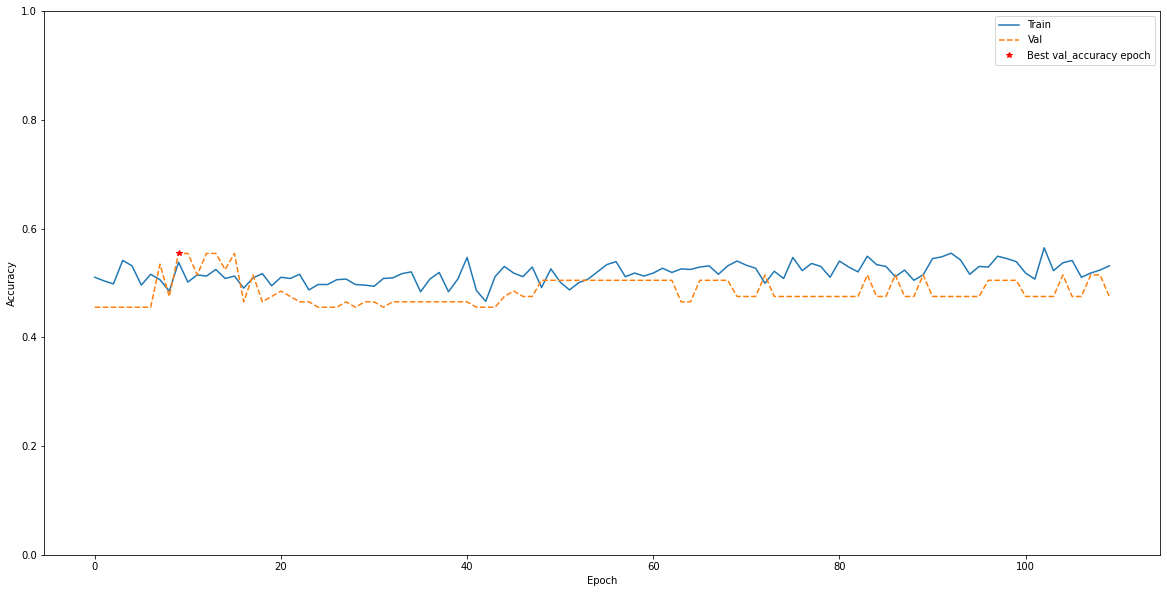

In [ ]:
plt.figure(figsize=(20,10))
plot_metric(histories[0],'accuracy',monitor_mode)

Vemos que en el epoch **`completar aquí`** se obtuvo la mejor loss de validación (asterisco rojo). Teoricamente, a partír de ahi la `loss` de validación empieza a alejarse de la de entrenamiento y se da el overfitting, por eso decidimos usar el modelo de ese epoch para ser evaluado. 

Notesé además que debido al mecanismo de corte temprano, no llegamos a los `500` epochs que seteamos al principio.

Ahora vamos a evaluar el modelo final sobre el `train` y `test` set para ver como se comportan sus medidas al momento de generalizar. Además veremos su matríz de confusión 

In [ ]:
'''
  Función para graficar e imprimir la matriz de confusión y medidas comparando un vector de predicciones vs su ground truth
'''
def plot_cm(labels, predictions, p=0.5):

  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total : ', np.sum(cm[1]))



Train results

loss :  0.6921249628067017
tp :  43.0
fp :  23.0
tn :  422.0
fn :  415.0
accuracy :  0.514950156211853
precision :  0.6515151262283325
recall :  0.09388646483421326
auc :  0.5040553212165833

Test results

loss :  0.6960626840591431
tp :  3.0
fp :  5.0
tn :  54.0
fn :  50.0
accuracy :  0.5089285969734192
precision :  0.375
recall :  0.056603774428367615
auc :  0.4245283007621765

Confusion matrix

True Negatives:  54
False Positives:  5
False Negatives:  50
True Positives:  3
Total :  53


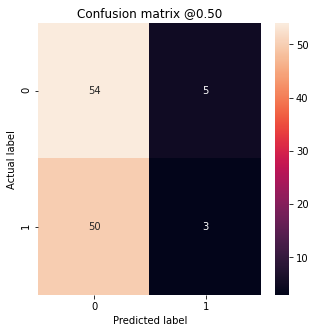

In [ ]:
test_predictions = model.predict(X_test, batch_size=batch_size)

print('Train results')
print()
results = model.evaluate(X_train, train_y,batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
  if name == 'loss':
    train_loss.append(value)
  elif name == 'precision':
    train_pres.append(value)
  elif name == 'recall':
    train_recs.append(value)
  elif name == 'accuracy': 
    train_accs.append(value)
print()

print('Test results')
print()
results = model.evaluate(X_test, test_y,batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
  if name == 'loss':
    test_loss.append(value)
  elif name == 'precision':
    test_pres.append(value)
  elif name == 'recall':
    test_recs.append(value)
  elif name == 'accuracy': 
    test_accs.append(value)
print()

print('Confusion matrix')
print()
plot_cm(test_y, test_predictions)

Recordamos que una  matriz de confusión reporta en la celda `(i,j)` la cantidad de casos con la etiqueta `i`, pero que fueron clasificados como `j`. En este problema particular las celdas reportan:
* `(0,0)` : `True negatives`
* `(1,1)` : `True positives`
* `(1,0)` : `False negatives`
* `(0,1)` : `False positives`


#### Observando la matriz, ¿Cual es la proporción de casos positivos que se encontraron correctamente?

In [ ]:
positivos_encontrados_1 = ?
print('Positivos encontrados {} % '.format(positivos_encontrados_1 * 100.0))

SyntaxError: ignored

#### ¿Con qué metrica se corresponde este valor?

In [ ]:
metrica_positivos_encontrados_1 = ?

#### De los casos clasificados como positivos, ¿Cual es la proporción de ellos que realmente fueron positivos? 

In [ ]:
positivos_correctos_1 = ?
print('Positivos correctos {} % '.format(positivos_correctos_1 * 100.0))

#### ¿Con qué metrica se corresponde este valor?

In [ ]:
metrica_positivos_correctos_1 = ? 

#### ¿Cuales son las ventajas de este modelo y cuales son sus desventajas?

In [ ]:
ventajas_desventajas_1 = ?

A continuación, probamos un modelo mas profundo, con 2 capas. Para esto llamamos de nuevo a la función `get_nnet_model` pero usando una lista de 2 elementos para parametrizar las capas intermedias.








In [ ]:
layers = [1/2,1/4]
model,history = get_nnet_model(X_train,train_y,X_val,val_y,None,layers,epochs,batch_size,early_stop_patience,monitor_metric,monitor_mode)

n_layers.append(len(layers))
models.append(model)
histories.append(history)

best_epoch,best_metric = get_best_epoch(history,monitor_metric,monitor_mode)
best_epochs.append(best_epoch)
best_metrics.append(best_metric)

print(model.summary())


Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.7871 - tp: 254.0000 - fp: 263.0000 - tn: 182.0000 - fn: 204.0000 - accuracy: 0.4828 - precision: 0.4913 - recall: 0.5546 - auc: 0.4828 - val_loss: 0.6975 - val_tp: 47.0000 - val_fp: 52.0000 - val_tn: 2.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.4851 - val_precision: 0.4747 - val_recall: 1.0000 - val_auc: 0.4963

Epoch 00001: val_accuracy improved from -inf to 0.48515, saving model to nnet_2_mid_layers.model
INFO:tensorflow:Assets written to: nnet_2_mid_layers.model/assets
Epoch 2/500
1/1 [==============================] - 0s 25ms/step - loss: 0.7676 - tp: 275.0000 - fp: 260.0000 - tn: 185.0000 - fn: 183.0000 - accuracy: 0.5094 - precision: 0.5140 - recall: 0.6004 - auc: 0.5061 - val_loss: 0.6964 - val_tp: 45.0000 - val_fp: 42.0000 - val_tn: 12.0000 - val_fn: 2.0000 - val_accuracy: 0.5644 - val_precision: 0.5172 - val_recall: 0.9574 - val_auc: 0.4909

Epoch 00002: val_accuracy improved from 0.48515 to 0.56436, savi

### Algunas preguntas sobre este modelo :
#### 1) Si la capa de entrada tiene 43 neuronas (43 variables de entrada), ¿ Cuantás neuronas tiene la **SEGUNDA** capa densa intermedia?



In [ ]:
n_neuronas_2mid_layer_2 = ?
print('La SEGUNDA capa intermedia tiene {} neuronas'.format(n_neuronas_2mid_layer_2))

SyntaxError: ignored

#### 2) Dado que la **SEGUNDA** capa intermedia es densa, ¿Cuantos pesos tenemos que ajustar aproximadamente?


In [ ]:
n_pesos_2mid_layer_2 = ?
print('La capa intermedia tiene aproximadamente {} pesos por optimizar'.format(n_pesos_2mid_layer_2))

SyntaxError: ignored

#### 3) La salida obviamente tiene solo una neurona, pero también está densamente conectada con la capa capa anterior (**SEGUNDA** capa intermedia), ¿Cuantos pesos tenemos que optimizar en esta capa para este modelo? 


In [ ]:
n_pesos_last_layer_2 = ?
print('La capa final tiene {} pesos por optimizar'.format(n_pesos_last_layer_2))

Nuevamente graficamos la historia de la _loss_ de entrenamiento y validación para este modelo. 

In [ ]:
plt.figure(figsize=(20,10))
plot_metric(histories[1],'accuracy','max')

Ahora vamos a evaluar el modelo final sobre el `train` y `test` set para ver como se comportan sus medidas al momento de generalizar. Además veremos su matríz de confusión 

Train results

loss :  0.694230854511261
tp :  423.0
fp :  360.0
tn :  85.0
fn :  35.0
accuracy :  0.5625692009925842
precision :  0.540229856967926
recall :  0.9235807657241821
auc :  0.5194592475891113

Test results

loss :  0.6988270878791809
tp :  49.0
fp :  50.0
tn :  9.0
fn :  4.0
accuracy :  0.5178571343421936
precision :  0.49494948983192444
recall :  0.9245283007621765
auc :  0.494403600692749

Confusion matrix

True Negatives:  9
False Positives:  50
False Negatives:  4
True Positives:  49
Total :  53


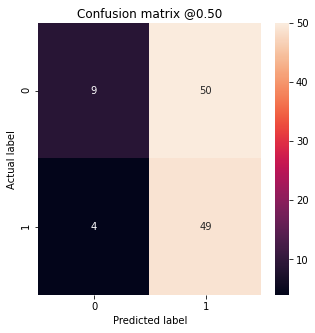

In [ ]:
test_predictions = model.predict(X_test, batch_size=batch_size)

print('Train results')
print()
results = model.evaluate(X_train, train_y,batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
  if name == 'loss':
    train_loss.append(value)
  elif name == 'precision':
    train_pres.append(value)
  elif name == 'recall':
    train_recs.append(value)
  elif name == 'accuracy': 
    train_accs.append(value)
print()

print('Test results')
print()
results = model.evaluate(X_test, test_y,batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
  if name == 'loss':
    test_loss.append(value)
  elif name == 'precision':
    test_pres.append(value)
  elif name == 'recall':
    test_recs.append(value)
  elif name == 'accuracy': 
    test_accs.append(value)
print()

print('Confusion matrix')
print()
plot_cm(test_y, test_predictions)


#### Observando esta matriz, ¿Cual es la _recall_ obtenida por este modelo?

In [ ]:
positivos_encontrados_2 = ?
print('Positivos encontrados {} % '.format(positivos_encontrados_2 * 100.0))

#### ¿Es este modelo mejor para capturar casos positivos?
(use `True` o `False` para esta respuesta) 

In [ ]:
recall_2_better_1 = ?

#### ¿Cual es la precisión de este modelo?

In [ ]:
positivos_correctos_2 = ?
print('Positivos correctos {} % '.format(positivos_correctos_2 * 100.0))

#### Observando la precisión, ¿Cual es la contra de tener un modelo bueno para capturar casos positivos?

In [ ]:
ventajas_desventajas_2 = ?

Probamos con un modelo más profundo aun, de 4 capas

In [ ]:
layers = [1/2,1/4,1/8,1/16]
model,history = get_nnet_model(X_train,train_y,X_val,val_y,None,layers,epochs,batch_size,early_stop_patience,monitor_metric,monitor_mode)

n_layers.append(len(layers))
models.append(model)
histories.append(history)

best_epoch,best_metric = get_best_epoch(history,monitor_metric,monitor_mode)
best_epochs.append(best_epoch)
best_metrics.append(best_metric)

print(model.summary())


Graficamos la evolución del entrenamiento.

In [ ]:
plt.figure(figsize=(20,10))
plot_metric(histories[2],'accuracy','max')

Evaluamos este nuevo modelo.

Train results

loss :  0.694230854511261
tp :  423.0
fp :  360.0
tn :  85.0
fn :  35.0
accuracy :  0.5625692009925842
precision :  0.540229856967926
recall :  0.9235807657241821
auc :  0.5194592475891113

Test results

loss :  0.6988270878791809
tp :  49.0
fp :  50.0
tn :  9.0
fn :  4.0
accuracy :  0.5178571343421936
precision :  0.49494948983192444
recall :  0.9245283007621765
auc :  0.494403600692749

Confusion matrix

True Negatives:  9
False Positives:  50
False Negatives:  4
True Positives:  49
Total :  53


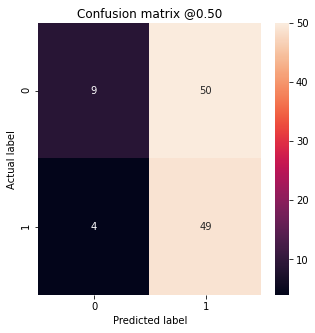

In [ ]:
test_predictions = model.predict(X_test, batch_size=batch_size)

print('Train results')
print()
results = model.evaluate(X_train, train_y,batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
  if name == 'loss':
    train_loss.append(value)
  elif name == 'precision':
    train_pres.append(value)
  elif name == 'recall':
    train_recs.append(value)
  elif name == 'accuracy': 
    train_accs.append(value)
print()

print('Test results')
print()
results = model.evaluate(X_test, test_y,batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
  if name == 'loss':
    test_loss.append(value)
  elif name == 'precision':
    test_pres.append(value)
  elif name == 'recall':
    test_recs.append(value)
  elif name == 'accuracy': 
    test_accs.append(value)
print()

print('Confusion matrix')
print()
plot_cm(test_y, test_predictions)


#### ¿Que pasa si el modelo es más profundo aún?

Implemente el codigo necesario para entrenar un modelo de 5 capas de manera de entendér que tenencias se ven al seguir complejizando las redes. 

In [ ]:
# 1 : construir y entrenar el modelo
layers = [1/2,1/4,1/8,1/16,?]
model,history = get_nnet_model(X_train,train_y,X_val,val_y,None,layers,epochs,batch_size,early_stop_patience,monitor_metric,monitor_mode)

n_layers.append(len(layers))
models.append(model)
histories.append(history)

best_epoch,best_metric = get_best_epoch(history,monitor_metric,monitor_mode)
best_epochs.append(best_epoch)
best_metrics.append(best_metric)

print(model.summary())


#### ¿Cual es la cantidad de parametros total de este nuevo modelo?

In [ ]:
total_pesos_4 = ?
print('El total de pesos aproximados para este modelo es {}'.format(total_pesos_4))

Repetimos el segundo paso del flujo general, que es graficar la historia de entrenamiento para ver el epoch de corte. 

In [ ]:
# 2 : plotear la loss del nuevo modelo 
plt.figure(figsize=(20,10))
plot_metric(histories[?],'precision','max')

#### ¿ Cual fué el mejor `epoch` y cual fué la `loss` en ese epoch?

In [ ]:
best_epoch_4 = ?
best_loss_4 = ?
print('La mejor loss fue {} y se logró en el epoch {}'.format(best_loss_4,best_epoch_4))

In [ ]:
# 3 : evaluación de metricas
test_predictions = model.predict(X_test, batch_size=batch_size)

print('Train results')
print()
results = model.evaluate(X_train, train_y,batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
  if name == 'loss':
    train_loss.append(value)
  elif name == 'precision':
    train_pres.append(value)
  elif name == 'recall':
    train_recs.append(value)
  elif name == 'accuracy': 
    train_accs.append(value)
print()

print('Test results')
print()
results = model.evaluate(X_test, test_y,batch_size=batch_size, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
  if name == 'loss':
    test_loss.append(value)
  elif name == 'precision':
    test_pres.append(value)
  elif name == 'recall':
    test_recs.append(value)
  elif name == 'accuracy': 
    test_accs.append(value)
print()

print('Confusion matrix')
print()
plot_cm(test_y, test_predictions)


#### Observando estos resultados, ¿Cual es la _recall_ obtenida por este modelo?

In [ ]:
positivos_encontrados_4 = ?
print('Positivos encontrados {} % '.format(positivos_encontrados_4 * 100.0))

#### ¿Cual es la precisión de este modelo?

In [ ]:
positivos_correctos_4 = ?
print('Positivos correctos {} % '.format(positivos_correctos_2 * 100.0))

Vamos a construir una tabla con los resultados obtenidos para cada modelo y así poder comparar cual de ellos se comportó mejor para elegir uno y continuar el analisis.

In [ ]:
experiment_results = pd.DataFrame(
  {
    'n_layers' : n_layers,
    'best_epochs' : best_epochs,
    'best_metrics' : best_metrics,
    'train_loss' : train_loss,
    'test_loss' : test_loss,
    'train_precs' : train_pres,
    'test_precs' : test_pres,
    'train_recs' : train_recs,
    'test_recs' : test_recs,
    'train_accs' : train_accs,
    'test_accs' : test_accs
  }
)

experiment_results

Ahora vamos a graficar algunas medidas de interés en función de la cantidad de capas del modelo. 

Nos vamos a enfocar en :
* **Recall** : recordemos que es el porcentaje de casos positivos encontramos 
* **Precision** : recordemos que es la proporcion de los detectados como positivos, que lo es realmente
* **Accuracy** : proporcion del total de ejemplos que se classifico correctamente ( `TP + TN / Total` ) 
* **Loss** : medida utilizada para ajustar el modelo, en este caso la [`Binary Cross Entropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)

In [ ]:

fig,axs = plt.subplots(2,2,figsize=(20,10))

pre_ax = axs[0,0]
sns.lineplot(data=experiment_results,x='n_layers',y='train_precs',label='Train Precision',ax=pre_ax)
sns.lineplot(data=experiment_results,x='n_layers',y='test_precs',label='Test Precision',ax=pre_ax)
pre_ax.set_ylabel('Precision')

rec_ax = axs[0,1]
sns.lineplot(data=experiment_results,x='n_layers',y='train_recs',label='Train Recall',ax = rec_ax)
sns.lineplot(data=experiment_results,x='n_layers',y='test_recs',label='Test Recall',ax = rec_ax)
rec_ax.set_ylabel('Recall')

accs_ax = axs[1,0]
sns.lineplot(data=experiment_results,x='n_layers',y='train_accs',label='Train Accuracy',ax = accs_ax )
sns.lineplot(data=experiment_results,x='n_layers',y='test_accs',label='Test Accuracy',ax = accs_ax )
accs_ax.set_ylabel('Accuracies')



loss_ax = axs[1,1]
sns.lineplot(data=experiment_results,x='n_layers',y='train_loss',label='Train Loss',ax = loss_ax)
sns.lineplot(data=experiment_results,x='n_layers',y='test_loss',label='Test Loss',ax = loss_ax)
loss_ax.set_ylabel('Loss')




#### ¿Que comportamiento observa en función de la cantidad de capas (profundidad) de las redes?

In [ ]:
conclusion_performance_vs_deep = ?

#### ¿Cual considera que es la "mejor" cantidad de capas ?

In [ ]:
mejor_cantidad_capas = ?
print('El mejor modelo es el que tiene {} capas'.format(mejor_cantidad_capas))

In [ ]:
# elegimos el modelo que tiene la mejor cantidad de capas
best_model_index = n_layers.index(mejor_cantidad_capas)
best_model = models[best_model_index]
best_model.summary()

## PARTE III : Conclusiones finales

Habiendo realizado este laboratorio complete las consignas a continuación. Note que no hay respuestas correctas, esta sección pretende servir para hacer una auto-reflexión y revisión de los conceptos vistos.

#### (1) Menciona 3 cosas que aprendiste con este laboratorio 

_Complete en esta celda sin limite de palabras ni formato_

#### (2) Menciona 3 cosas que aún no entendés del todo y cual es tu intuición sobre ellas 

_Complete en esta celda sin limite de palabras ni formato_


_Si querés te invitamos a investigar más o preguntar para aclarar estos conceptos_

#### (3) Menciona 3 ideas / cosas que harías a partír de aquí para mejorar los resultados

_Complete en esta celda sin limite de palabras ni formato_


## Appendice : Usando la red neuronal para predecir resultados de test
Ahora que tenemos un modelo base para trabajar, vamos a tratar de utilizarlo en la práctica para hacer algunas predicciones y ver como se comporta.

En primer lugar obtenemos una muestra de ejemplos positivos para ver como los evalua este modelo.

In [ ]:
positive_test = test_df.loc[test_df[target_variable] == 'positive']
print(positive_test.shape)
positive_test.sample(5)

(53, 81)


,Alanine transaminase,Monocytes,Ferritin,Myelocytes,Sodium,Neutrophils,y,Mean platelet volume,Aspartate transaminase,Proteina C reativa mg/dL,pH (venous blood gas analysis),Urine - Crystals,Urine - Protein,Alkaline phosphatase,Urine - Aspect,Urine - pH,Hemoglobin,Urine - Hyaline cylinders,ctO2 (arterial blood gas analysis),Myeloblasts,International normalized ratio (INR),Mean corpuscular hemoglobin concentration (MCHC),Serum Glucose,Platelets,Hematocrit,Direct Bilirubin,Urine - Urobilinogen,Eosinophils,Strepto A,Hb saturation (arterial blood gases),Urine - Red blood cells,Urine - Leukocytes,Leukocytes,SARS-Cov-2 exam result,Base excess (venous blood gas analysis),Phosphor,HCO3 (venous blood gas analysis),Gamma-glutamyltransferase,Potassium,Urine - Esterase,...,Urine - Yeasts,Magnesium,Urine - Density,Creatinine,HCO3 (arterial blood gas analysis),Mean corpuscular volume (MCV),Arteiral Fio2,Lactic Dehydrogenase,Albumin,Total Bilirubin,pO2 (venous blood gas analysis),Lymphocytes,Urine - Ketone Bodies,Rods #,Mean corpuscular hemoglobin (MCH),Basophils,Lipase dosage,Arterial Lactic Acid,Segmented,Total CO2 (arterial blood gas analysis),Urine - Hemoglobin,Urine - Color,Relationship (Patient/Normal),Urine - Bile pigments,Total CO2 (venous blood gas analysis),Urea,Indirect Bilirubin,Hb saturation (venous blood gas analysis),pO2 (arterial blood gas analysis),Metamyelocytes,Creatine phosphokinase (CPK),Base excess (arterial blood gas analysis),Red blood cell distribution width (RDW),Red blood Cells,Promyelocytes,pCO2 (arterial blood gas analysis),Ionized calcium,Urine - Granular cylinders,pH (arterial blood gas analysis),Patient age quantile
5639,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5560,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2241,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
3471,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
2993,NaN,1.145443,NaN,NaN,NaN,-0.537138,1,0.010677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.105468,NaN,NaN,NaN,NaN,0.74204,NaN,-0.517413,0.96895,NaN,NaN,-0.203417,NaN,NaN,NaN,NaN,-0.417414,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.074163,NaN,NaN,NaN,NaN,NaN,0.292779,NaN,NaN,0.230447,-0.223767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.524862,0.87774,NaN,NaN,NaN,NaN,NaN,4


A partir del dataframe de ejemplos positivos necesitamos obtener los datapoints en el formato esperado por el modelo. Para ello implementamos la función `get_datapoints_sample_model` .

#### Complete el código en los signos de interrogación para implementar esa función

In [ ]:

'''
  Función para transformar un dataframe tomado de un dataset similar al usado para entrenar y generar un arreglo de datapoints para predecir
'''
def get_datapoints_sample_model(
    df, # dataframe de entrada
    scaler_numeric, # objeto Scaler usado para generar el trainset
    numeric_vars, # columnas de variables numericas en el dataframe
    imputer # imputer object
    ):
  
  # obtenenmos las matrices resultado de transofrmar el dataframe a todo numérico
  _numeric,_y = ?

  # aplicamos el preprocesamiento anterior
  _numeric = ?.transform(_numeric)
  _numeric = ?.transform(_numeric)
  list_input_matrix = [_numeric]
  
  
  # bind all the X_ matrix in one
  _datapoints = np.hstack(tuple(list_input_matrix ))
  return _datapoints


SyntaxError: ignored

Usando la función anterior obtenemos la matriz de `datapoints` la cual es pasada a la función `predict_classes` del mejor modelo para predecir sobre ellos y obtener un valor `1` si el modelo cree que el ejemplo es COVID positivo y un valor `0` si cree que es negativo.

In [ ]:
datapoints = get_datapoints_sample_model(positive_test,
                                         scaler_numeric,
                                         numeric_vars,
                                         imputer)
print(datapoints.shape)
postive_datapoints_predictions = best_model.predict_classes(datapoints)[:,0]
print('Resultados de predicciones sobre una muestra de casos positivos: \n{}'.format(postive_datapoints_predictions))

#### ¿Cuantos de los ejemplos se predijeron correctamente como positivos?


In [ ]:
n_true_positives = ?
print('{} de los {} ejemplos positivos se predijeron correctamente como tales'.format(n_true_positives, datapoints.shape[0])) 

De la matriz `datapoints` vamos a extraér solamente los casos que se predijeron correctamente para analizar los mismos que es donde el modelo es bueno. 

In [ ]:
true_poistives_index = np.where(postive_datapoints_predictions == 1)
true_positives_datapoints = datapoints[true_poistives_index,:][0]
print(true_positives_datapoints.shape)
true_positives_datapoints

A continuación usaremos el modulo [SHAP](https://github.com/slundberg/shap) para entender mejor las predicciones del modelo y ver cuales son las variables que más influencian el valor de la neurona de salida. 

Usaremos el objeto `KernelExplainer` para obtener los _SHAP Values_ sobre la matriz de datapoints. Sin entrar en detalles, estos valores nos dicen en promedio cuanto movió, positiva o negativamente el valor de la neurona de salida de un valor base (predicción promedio sobre el trainset). [Lectura recomendada para más detalle](https://christophm.github.io/interpretable-ml-book/shapley.html)

In [ ]:
!pip install shap
import shap 

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train,100))
shap_values_tp = explainer.shap_values(true_positives_datapoints)

Usando los `shap_values` podemos graficarlos en un [`summary_plot`](https://christophm.github.io/interpretable-ml-book/shap.html#shap-summary-plot) donde vemos a la izquierda las variables que más influencian las predicciones y en linea con el nombre de la variable se ubica un punto por cada ejemplo donde los puntos más hacia la derecha han movido la prediccion positivamente y aquellos más a la izquierda la han movido negativamente. Además los puntos tienen un color que corresponde con el valor que tuvo ese ejemplo en la variable en cuestión. 

In [ ]:
feature_names = numeric_vars
shap.summary_plot(shap_values_tp[0], true_positives_datapoints,feature_names=feature_names)

Analizamos ahora como se comporta para algunos casos negativos repitiendo el proceso anterior.

In [ ]:
negative_test = test_df.loc[test_df[target_variable] == 'negative']
print(negative_test.shape)
negative_test.head(3)

In [ ]:
datapoints = get_datapoints_sample_model(negative_test,
                                         scaler_numeric,
                                         numeric_vars,
                                         imputer)

print(datapoints.shape)
negative_datapoints_predictions = best_model.predict_classes(datapoints)[:,0]
print('Resultados de predicciones sobre una muestra de casos negativos: \n{}'.format(negative_datapoints_predictions))

#### ¿Cuantos de los ejemplos se predijeron correctamente como `negativos`?


In [ ]:
n_true_negatives = ?
print('{} de los {} ejemplos negativos se predijeron correctamente como tales'.format(n_true_negatives,datapoints.shape[0])) 

In [ ]:
true_negatives_index = np.where(negative_datapoints_predictions == 0)
true_negatives_datapoints = datapoints[true_negatives_index,:][0]
print(true_negatives_datapoints.shape)
true_negatives_datapoints

In [ ]:
# use Kernel SHAP to explain test set predictions
shap_values_tn = explainer.shap_values(true_negatives_datapoints)

In [ ]:
feature_names = numeric_vars
shap.summary_plot(shap_values_tn[0], true_negatives_datapoints,feature_names=feature_names)

#### Considerando estas muestras, ¿cual es la `precision`, `recall` y `accuracy`?

In [ ]:
precision_predictions = ?

print('La precisión estimada para esta muestra es de {} %'.format(precision_predictions))

recall_predictions = ?

print('La recall estimada para esta muestra es de {} %'.format(recall_predictions))

accuracy_predictions = ?

print('La accuracy estimada para esta muestra es de {} %'.format(accuracy_predictions))